<a href="https://colab.research.google.com/github/OrugboGodswill/Real-time-News-Analysis-with-Newapi/blob/main/Real_time_News_Analysis_with_Newapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dotenv wordcloud


In [2]:
# Colab: run once
!pip install -q scikit-learn nltk openpyxl joblib

# Imports
import re
import logging
from typing import List, Tuple
from pathlib import Path

import requests
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import joblib

# nltk for optional tokenization / stopwords
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Logging config
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

# Ensure reproducible matplotlib backend for notebooks
%matplotlib inline


In [3]:
from datetime import datetime, timedelta

load_dotenv()
os.environ["NEWSAPI_KEY"] = "d66c985b1d96429a94ee872cb6c7f1e5"
api_key = os.getenv("NEWSAPI_KEY")

# dates for the last 2 days
to_date = datetime.now().date()
from_date = to_date - timedelta(days=30)

QUERY = ' AGI on chinaAGI OR GLOBAL AI OR FIRSTAGI'
LANG = 'en'
page_size = 20  # max per page

def fetch_news(QUERY, from_date, to_date, api_key, page_size=20):
    url = 'https://newsapi.org/v2/everything'
    all_articles = []
    for page in range(1, 6):  # try up to 5 pages
        params = {
            'q': QUERY,
            'from': from_date,
            'to': to_date,
            'language': LANG,
            'pageSize': page_size,
            'page': page,
            'sortBy': 'publishedAt',
            'apiKey': api_key
        }
        response = requests.get(url, params=params)
        data = response.json()

        if data.get("status") != "ok":
            print("Error:", data.get("message"))
            break

        articles = data.get("articles", [])
        if not articles:
            break
        all_articles.extend(articles)
    return all_articles

In [4]:
# fetch articles
articles = fetch_news(QUERY, from_date.isoformat(), to_date.isoformat(), api_key)

# convert to dataframe
df = pd.DataFrame([{
    'title': article['title'],
    'description': article['description'],
    'author': article['author'],
    'urlToImage': article['urlToImage'],
    'source': article['source']['name'],
    'published_at': article['publishedAt'],
    'url': article['url'],
    'content': article['content']
} for article in articles])

# save to CSV
df.to_csv("aGI.csv", index=False)
print(f"{len(df)} articles saved to 'aGI.csv'")

df.to_excel("aGI.xlsx", index=False)
print(f"{len(df)} articles saved to 'aGI.xlsx'")

99 articles saved to 'aGI.csv'
99 articles saved to 'aGI.xlsx'


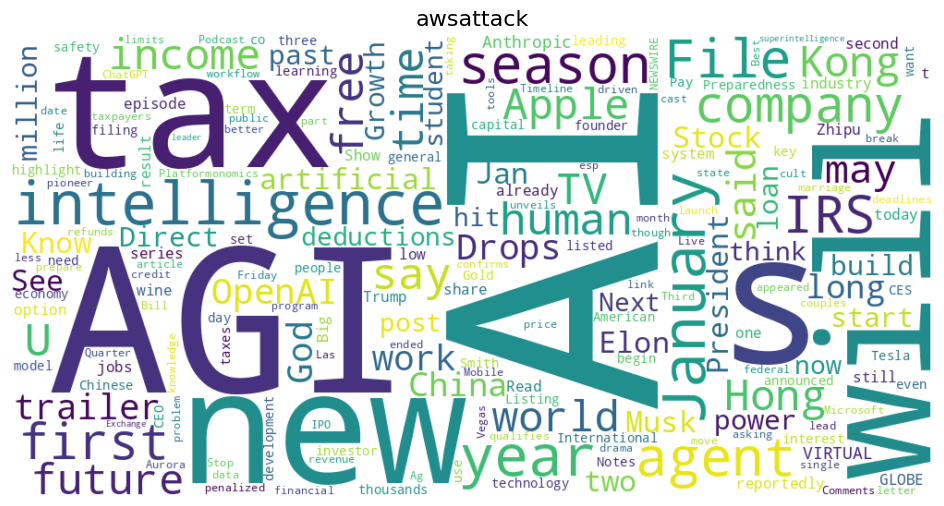

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# combine title and description text for word cloud
text_data = df['title'].fillna('').astype(str) + ' ' + df['description'].fillna('').astype(str)
combined_text = ' '.join(text_data.tolist())
ct = text_data.str.lower()

# generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white', collocations=False).generate(combined_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("awsattack", fontsize=16)
plt.show()

In [6]:
# Output folder for artifacts
OUTDIR = Path("artifacts")
OUTDIR.mkdir(exist_ok=True)

CUSTOM_STOPWORDS = {
    "said"
}

All_Stopwords = ENGLISH_STOP_WORDS.union(CUSTOM_STOPWORDS)
# Safe config for CountVectorizer (tune these for your data)
VECT_CONFIG = {
    "ngram_range": (1, 2),      # include unigrams + bigrams
    "stop_words": list(All_Stopwords),    # built-in english stop words
    "min_df": 2,                # appear in at least 2 docs
    "max_df": 0.9,              # ignore words in >90% of docs (very common)
    "token_pattern": r'(?u)\b[a-zA-Z]{3,}\b',  # only letters, length >=3
    "max_features": 10000       # limit vocab size for production memory control
}


vectorizer = CountVectorizer(**VECT_CONFIG)
logger.info("Fitting CountVectorizer with config: %s", {k: VECT_CONFIG[k] for k in ["ngram_range","min_df","max_features"]})
X = vectorizer.fit_transform(ct)
logger.info("Vectorizer built; vocab size=%d; doc-term shape=%s", len(vectorizer.get_feature_names_out()), X.shape)
sum_token = X.sum(axis=0)
tokens = vectorizer.get_feature_names_out()

In [7]:
# Create a DataFrame of token frequencies
token_frequencies = pd.DataFrame({'token': tokens, 'frequency': sum_token.A1})

# Sort by frequency in descending order and display the top tokens
token_frequencies = token_frequencies.sort_values(by='frequency', ascending=False)

print("Most Frequent Keywords:")
display(token_frequencies.head(20)) # Display the top 20 for brevity

Most Frequent Keywords:


,token,frequency
8,agi,37
330,tax,23
226,new,21
158,intelligence,19
171,january,19
288,season,15
108,file,15
165,irs,14
383,year,13
58,company,13
